## 第十週：主題模型

## 1. 資料前處理

In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['axes.unicode_minus']=False

In [4]:
# 從PPT取得憂鬱版的資料，時間從2022年4月到2024年4月

ppt = pd.read_csv("raw_data/depression.csv")  # 匯資料
ppt = ppt.dropna()
ppt = ppt[ppt['artCatagory'] != 'artCatagory']
ppt.reset_index()

,index,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,0,1,https://www.ptt.cc/bbs/prozac/M.1650303219.A.4...,[陰天]身體,2022-04-19 01:33:37,yoshi9145,prozac,今天打疫苗順便問了醫生身體一直存在不舒服的症狀\n雖然兩年前檢查過沒診斷出什麼\n但是這症狀...,[],211.20.236.198,2022-04-19 02:07:52,ptt
1,1,2,https://www.ptt.cc/bbs/prozac/M.1650331853.A.C...,[陰天]自信,2022-04-19 09:30:51,merpheus,prozac,沒自信真是我的致命傷\n\n其實腦中都可以想像自信的樣子要怎麼演\n\n但實際想演的時候就縮...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""doublehelix""...",223.138.127.164,2022-04-20 02:08:46,ptt
2,2,3,https://www.ptt.cc/bbs/prozac/M.1650344674.A.D...,[陰天]醫生,2022-04-19 13:04:32,epoch3004,prozac,這兩個月跑去大醫院看\n原本以為長效針還有效\n結果還是沒辦法 無感了\n不知道要怎麼辦\n...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""koxinga"", ""c...",61.58.108.146,2022-04-20 02:08:46,ptt
3,3,4,https://www.ptt.cc/bbs/prozac/M.1650366635.A.8...,[陰天]每天清晨（雷）,2022-04-19 19:10:33,isaki1987,prozac,早醒 魚肚白時我都很恐懼\n因為一天又要開始了\n我想詳述過程應該又會犯法\n總之我還是滿懷...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""MDFK55"", ""cm...",24.148.7.230,2022-04-20 02:08:46,ptt
4,4,5,https://www.ptt.cc/bbs/prozac/M.1650376100.A.B...,[閒聊]文昌,2022-04-19 21:48:18,MDFK55,prozac,仙風道骨本天生。\n又遇仙宗為主盟。\n指日丹成謝巖谷。\n一朝引領向天行。\n雷雨師籤百首...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""merpheus"", ""...",223.136.61.45,2022-04-20 02:08:46,ptt
...,...,...,...,...,...,...,...,...,...,...,...,...
7442,7482,7483,https://www.ptt.cc/bbs/prozac/M.1713179853.A.E...,[閒聊]走47min16sec感冒了,2024-04-15 19:17:30,kazusn,prozac,爸爸感冒了 沒有落實公筷母匙 我和媽媽跟姪子三個人都被傳染了\n\n吃斯斯 吃維他命C 希望...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""emilucute"", ...",61.223.205.89,2024-04-16 02:08:55,ptt
7443,7483,7484,https://www.ptt.cc/bbs/prozac/M.1713184738.A.B...,[閒聊]爆掉,2024-04-15 20:38:56,MDFK55,prozac,腳爆掉\n今天運動時走了52分鐘\n總共2.9公里\nhttps://i.imgur.com...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""timer000"", ""...",42.75.209.150,2024-04-16 02:08:55,ptt
7444,7484,7485,https://www.ptt.cc/bbs/prozac/M.1713188229.A.6...,[陰天]有沒有（雷）,2024-04-15 21:37:06,blest115,prozac,有沒有那麼一首歌，聽多慢歌很開心，可是聽久我又開始心情超差\n\n我需要歌曲宣洩，可是悲傷又...,[],223.136.45.255,2024-04-16 02:08:55,ptt
7445,7485,7486,https://www.ptt.cc/bbs/prozac/M.1713189909.A.B...,[陰天]記事夢,2024-04-15 22:05:07,hesione,prozac,"夢見和手足的爭執驚醒\n聽見父親出於煩惱的私下對話\n""喜歡在頭髮上的味道 明知很貴故意把人...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""ninjamaster""...",68.174.240.235,2024-04-16 02:08:55,ptt


In [5]:
# 移除網址格式
# 只留下中文字
ppt["artContent"] = ppt["artContent"].str.replace("(http|https)://.*", "", regex=True)
ppt["artTitle"] = ppt["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ppt["artContent"] = ppt["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ppt["artTitle"] = ppt["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ppt['content'] = ppt['artContent']


ppt = ppt.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
ppt.head(3)

,content,artUrl,artCatagory,artDate
0,今天打疫苗順便問了醫生身體一直存在不舒服的症狀雖然兩年前檢查過沒診斷出什麼但是這症狀一直存在...,https://www.ptt.cc/bbs/prozac/M.1650303219.A.4...,prozac,2022-04-19 01:33:37
1,沒自信真是我的致命傷其實腦中都可以想像自信的樣子要怎麼演但實際想演的時候就縮了好討厭自己也因...,https://www.ptt.cc/bbs/prozac/M.1650331853.A.C...,prozac,2022-04-19 09:30:51
2,這兩個月跑去大醫院看原本以為長效針還有效結果還是沒辦法無感了不知道要怎麼辦都無感了大醫院的醫...,https://www.ptt.cc/bbs/prozac/M.1650344674.A.D...,prozac,2022-04-19 13:04:32


In [7]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ppt["words"] = ppt["content"].apply(getToken)
ppt.head()

Building prefix dict from c:\Users\qweji\OneDrive\桌面\2024_winter_practice\SMA2024\SMA_2024S\week10\dict\dict.txt.big ...
2024-06-05 16:04:12,947 : DEBUG : Building prefix dict from c:\Users\qweji\OneDrive\桌面\2024_winter_practice\SMA2024\SMA_2024S\week10\dict\dict.txt.big ...
Dumping model to file cache C:\Users\qweji\AppData\Local\Temp\jieba.ub87aeb2cffc0a9b5a6516a02df02ae82.cache
2024-06-05 16:04:14,139 : DEBUG : Dumping model to file cache C:\Users\qweji\AppData\Local\Temp\jieba.ub87aeb2cffc0a9b5a6516a02df02ae82.cache
Loading model cost 1.293 seconds.
2024-06-05 16:04:14,241 : DEBUG : Loading model cost 1.293 seconds.
Prefix dict has been built successfully.
2024-06-05 16:04:14,243 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,今天打疫苗順便問了醫生身體一直存在不舒服的症狀雖然兩年前檢查過沒診斷出什麼但是這症狀一直存在...,https://www.ptt.cc/bbs/prozac/M.1650303219.A.4...,prozac,2022-04-19 01:33:37,"[今天, 疫苗, 順便, 問了, 醫生, 身體, 一直, 存在, 舒服, 症狀, 兩年, 檢..."
1,沒自信真是我的致命傷其實腦中都可以想像自信的樣子要怎麼演但實際想演的時候就縮了好討厭自己也因...,https://www.ptt.cc/bbs/prozac/M.1650331853.A.C...,prozac,2022-04-19 09:30:51,"[自信, 真是, 致命傷, 腦中, 想像, 自信, 樣子, 實際, 想演, 討厭, 育幼院,..."
2,這兩個月跑去大醫院看原本以為長效針還有效結果還是沒辦法無感了不知道要怎麼辦都無感了大醫院的醫...,https://www.ptt.cc/bbs/prozac/M.1650344674.A.D...,prozac,2022-04-19 13:04:32,"[兩個, 醫院, 原本, 以為, 長效, 針還, 有效, 辦法, 無感, 知道, 無感, 醫..."
3,早醒魚肚白時我都很恐懼因為一天又要開始了我想詳述過程應該又會犯法總之我還是滿懷焦慮地活著,https://www.ptt.cc/bbs/prozac/M.1650366635.A.8...,prozac,2022-04-19 19:10:33,"[早醒, 魚肚白, 恐懼, 一天, 詳述, 過程, 應該, 犯法, 滿懷, 焦慮, 地活]"
4,仙風道骨本天生又遇仙宗為主盟指日丹成謝巖谷一朝引領向天行雷雨師籤百首昨天去拜文昌抽到的籤詩加...,https://www.ptt.cc/bbs/prozac/M.1650376100.A.B...,prozac,2022-04-19 21:48:18,"[仙風道骨, 天生, 仙宗為, 主盟, 指日丹, 成謝, 一朝, 引領, 天行, 雷雨, 百..."


## 2. LDA 主題模型


**2.1 產生dictionary和corpus**

In [8]:
docs = ppt['words'].to_list()
docs[0]

['今天',
 '疫苗',
 '順便',
 '問了',
 '醫生',
 '身體',
 '一直',
 '存在',
 '舒服',
 '症狀',
 '兩年',
 '檢查',
 '過沒',
 '診斷',
 '症狀',
 '一直',
 '存在',
 '感覺',
 '普通',
 '常見',
 '那種',
 '問了',
 '醫生',
 '兩年',
 '需要',
 '檢查',
 '醫生',
 '建議',
 '檢查',
 '東西',
 '成長性',
 '這句',
 '心情',
 '放心',
 '尋常',
 '身體',
 '症狀',
 '追究',
 '原因',
 '未知',
 '恐懼',
 '襲來']

In [9]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.9)
print(dictionary)

2024-06-05 16:06:27,683 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-06-05 16:06:28,249 : INFO : built Dictionary<52638 unique tokens: ['一直', '今天', '兩年', '原因', '問了']...> from 7447 documents (total 480409 corpus positions)
2024-06-05 16:06:28,250 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<52638 unique tokens: ['一直', '今天', '兩年', '原因', '問了']...> from 7447 documents (total 480409 corpus positions)", 'datetime': '2024-06-05T16:06:28.250146', 'gensim': '4.3.1', 'python': '3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}
2024-06-05 16:06:28,288 : INFO : discarding 41983 tokens: [('成長性', 2), ('追究', 4), ('想演', 1), ('致命傷', 2), ('針還', 1), ('滿懷', 1), ('詳述', 3), ('魚肚白', 1), ('一朝', 2), ('主盟', 1)]...
2024-06-05 16:06:28,289 : INFO : keeping 10655 tokens which were in no less than 5 and no more than 6702 (=90.0%) documents
2024-06-05 16:06:28,313 : INF

Dictionary<10655 unique tokens: ['一直', '今天', '兩年', '原因', '問了']...>


In [10]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一直: 0
今天: 1
兩年: 2
原因: 3
問了: 4
存在: 5
尋常: 6
常見: 7
建議: 8
心情: 9
恐懼: 10
感覺: 11


In [11]:
pprint(" ".join(ppt['words'].iloc[600]))


'最近 垃圾 食物 每次 正常 食物 覺得 對不起 食物 垃圾 食物 覺得 心安理得 慢性 自殺'


In [12]:
dictionary.doc2bow(ppt['words'].iloc[600])[:10]

[(106, 2),
 (136, 1),
 (201, 1),
 (204, 1),
 (362, 1),
 (383, 1),
 (2267, 4),
 (2317, 1),
 (4258, 2),
 (5571, 1)]

In [13]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

訓練 topic model

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [33]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=3, # 生成幾個主題數
    random_state=4747, # 亂數
    iterations= 100
)

2024-06-05 16:47:14,739 : INFO : using symmetric alpha at 0.16666666666666666
2024-06-05 16:47:14,741 : INFO : using symmetric eta at 0.16666666666666666
2024-06-05 16:47:14,744 : INFO : using serial LDA version on this node
2024-06-05 16:47:14,753 : INFO : running online (single-pass) LDA training, 6 topics, 1 passes over the supplied corpus of 7447 documents, updating model once every 2000 documents, evaluating perplexity every 7447 documents, iterating 100x with a convergence threshold of 0.001000
2024-06-05 16:47:14,753 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-06-05 16:47:14,755 : INFO : PROGRESS: pass 0, at document #2000/7447
2024-06-05 16:47:16,588 : INFO : merging changes from 2000 documents into a model of 7447 documents
2024-06-05 16:47:16,592 : INFO : topic #4 (0.167): 0.017*"知道" + 0.010*"真的" + 0.008*"覺得" + 0.006*"現在" + 0.005*"一直" + 0.005*"好像" + 0.005*"感覺" + 0.005*"已經" + 0.004*"不

**2.2 查看 LDA 主題代表字** <br>

In [16]:
ldamodel.print_topics(num_words=10)

2024-06-05 16:10:56,045 : INFO : topic #0 (0.167): 0.008*"知道" + 0.007*"真的" + 0.007*"世界" + 0.007*"喜歡" + 0.006*"像是" + 0.006*"希望" + 0.006*"覺得" + 0.006*"現在" + 0.005*"人生" + 0.005*"也許"
2024-06-05 16:10:56,046 : INFO : topic #1 (0.167): 0.012*"工作" + 0.011*"覺得" + 0.008*"問題" + 0.007*"真的" + 0.007*"現在" + 0.006*"已經" + 0.006*"知道" + 0.006*"比較" + 0.006*"朋友" + 0.005*"對方"
2024-06-05 16:10:56,047 : INFO : topic #2 (0.167): 0.019*"醫生" + 0.011*"真的" + 0.011*"一直" + 0.011*"知道" + 0.011*"痛苦" + 0.011*"覺得" + 0.010*"今天" + 0.007*"現在" + 0.007*"工作" + 0.006*"已經"
2024-06-05 16:10:56,049 : INFO : topic #3 (0.167): 0.010*"覺得" + 0.010*"真的" + 0.009*"知道" + 0.007*"現在" + 0.006*"感覺" + 0.005*"不想" + 0.005*"一直" + 0.005*"情緒" + 0.004*"焦慮" + 0.004*"事情"
2024-06-05 16:10:56,050 : INFO : topic #4 (0.167): 0.014*"知道" + 0.013*"真的" + 0.010*"今天" + 0.008*"覺得" + 0.007*"現在" + 0.006*"已經" + 0.006*"不想" + 0.006*"一下" + 0.006*"感覺" + 0.005*"好像"
2024-06-05 16:10:56,052 : INFO : topic #5 (0.167): 0.006*"覺得" + 0.005*"喜歡" + 0.005*"看到" + 0.005*"台灣" + 0.

[(0,
  '0.008*"知道" + 0.007*"真的" + 0.007*"世界" + 0.007*"喜歡" + 0.006*"像是" + 0.006*"希望" + 0.006*"覺得" + 0.006*"現在" + 0.005*"人生" + 0.005*"也許"'),
 (1,
  '0.012*"工作" + 0.011*"覺得" + 0.008*"問題" + 0.007*"真的" + 0.007*"現在" + 0.006*"已經" + 0.006*"知道" + 0.006*"比較" + 0.006*"朋友" + 0.005*"對方"'),
 (2,
  '0.019*"醫生" + 0.011*"真的" + 0.011*"一直" + 0.011*"知道" + 0.011*"痛苦" + 0.011*"覺得" + 0.010*"今天" + 0.007*"現在" + 0.007*"工作" + 0.006*"已經"'),
 (3,
  '0.010*"覺得" + 0.010*"真的" + 0.009*"知道" + 0.007*"現在" + 0.006*"感覺" + 0.005*"不想" + 0.005*"一直" + 0.005*"情緒" + 0.004*"焦慮" + 0.004*"事情"'),
 (4,
  '0.014*"知道" + 0.013*"真的" + 0.010*"今天" + 0.008*"覺得" + 0.007*"現在" + 0.006*"已經" + 0.006*"不想" + 0.006*"一下" + 0.006*"感覺" + 0.005*"好像"'),
 (5,
  '0.006*"覺得" + 0.005*"喜歡" + 0.005*"看到" + 0.005*"台灣" + 0.004*"真的" + 0.004*"今天" + 0.004*"情緒" + 0.004*"現在" + 0.003*"人類" + 0.003*"心情"')]

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：

**2.3 計算 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
+ **perplexity** :<br>

In [35]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2024-06-05 16:49:17,284 : INFO : -8.261 per-word bound, 306.7 perplexity estimate based on a held-out corpus of 7447 documents with 412152 words


-8.260619354145005

In [53]:
np.exp(-perplexity)

0.0

In [19]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

2024-06-05 16:11:54,452 : INFO : using ParallelWordOccurrenceAccumulator<processes=11, batch_size=64> to estimate probabilities from sliding windows
2024-06-05 16:12:07,087 : INFO : 1 batches submitted to accumulate stats from 64 documents (2549 virtual)
2024-06-05 16:12:07,088 : INFO : 2 batches submitted to accumulate stats from 128 documents (4241 virtual)
2024-06-05 16:12:07,090 : INFO : 3 batches submitted to accumulate stats from 192 documents (7207 virtual)
2024-06-05 16:12:07,093 : INFO : 4 batches submitted to accumulate stats from 256 documents (9550 virtual)
2024-06-05 16:12:07,096 : INFO : 5 batches submitted to accumulate stats from 320 documents (11654 virtual)
2024-06-05 16:12:07,099 : INFO : 6 batches submitted to accumulate stats from 384 documents (15039 virtual)
2024-06-05 16:12:07,102 : INFO : 7 batches submitted to accumulate stats from 448 documents (17088 virtual)
2024-06-05 16:12:07,105 : INFO : 8 batches submitted to accumulate stats from 512 documents (20661 v

這個主題的 PMI score:  0.001303370824448968


In [20]:
NPMI_model_lda.get_coherence_per_topic()

[-8.152515666806242e-05,
 -0.0003315712312104145,
 0.015733159124321005,
 0.0055385853743478,
 0.00482316514039247,
 -0.01786158830448899]

**2.4 透過指標找出最佳主題數**

In [59]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 42,
        iterations= 100,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")


2024-06-05 17:12:10,696 : INFO : using symmetric alpha at 0.5
2024-06-05 17:12:10,698 : INFO : using symmetric eta at 0.5
2024-06-05 17:12:10,701 : INFO : using serial LDA version on this node
2024-06-05 17:12:10,705 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 7447 documents, updating model once every 2000 documents, evaluating perplexity every 7447 documents, iterating 100x with a convergence threshold of 0.001000
2024-06-05 17:12:10,706 : INFO : PROGRESS: pass 0, at document #2000/7447
2024-06-05 17:12:12,950 : INFO : merging changes from 2000 documents into a model of 7447 documents
2024-06-05 17:12:12,954 : INFO : topic #0 (0.500): 0.010*"知道" + 0.010*"覺得" + 0.009*"真的" + 0.006*"工作" + 0.005*"醫生" + 0.005*"現在" + 0.005*"一直" + 0.005*"不想" + 0.005*"事情" + 0.004*"感覺"
2024-06-05 17:12:12,954 : INFO : topic #1 (0.500): 0.009*"知道" + 0.009*"覺得" + 0.009*"真的" + 0.008*"現在" + 0.006*"已經" + 0.006*"工作" + 0.005*"一直" + 0.005*"今天" + 0.005*"醫生" + 0.004*

花費時間: 360.2581412792206 sec


In [60]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,3224.049714,0.001468
1,3,3220.946987,0.003261
2,4,3319.426111,0.015382
3,5,3343.112078,0.002810
4,6,3419.218829,-0.033637
5,7,3515.921697,-0.012300
6,8,3566.027793,-0.004928
7,9,3627.860654,-0.003289


<Axes: xlabel='topic_num'>

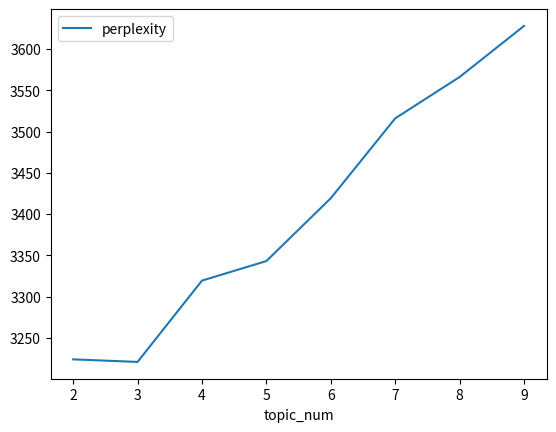

In [61]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

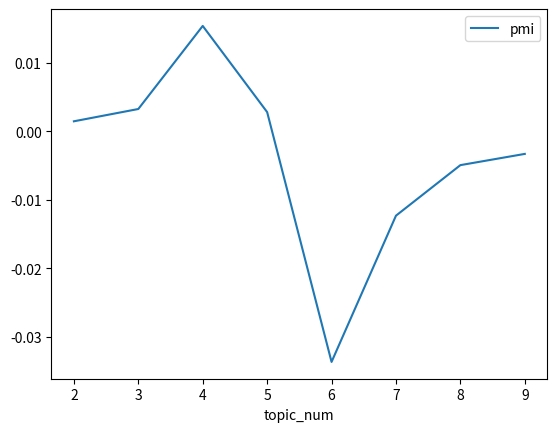

In [62]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 和 coherence 的表現最好是在3~5個主題數的時候

Perplexity隨著主題數增加而增加

Coherence的表現則是在主題數4時最高，6時達到最低

## 3. 視覺化呈現

**3.1 產生 LDAvis 結果**

以下用主題數 4 來做 LDAvis

In [64]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 3,
    id2word=dictionary,
    random_state = 42,
    iterations= 150,
    passes = 10 # 訓練次數
    )

2024-06-05 17:41:19,522 : INFO : using symmetric alpha at 0.3333333333333333
2024-06-05 17:41:19,524 : INFO : using symmetric eta at 0.3333333333333333
2024-06-05 17:41:19,527 : INFO : using serial LDA version on this node
2024-06-05 17:41:19,533 : INFO : running online (multi-pass) LDA training, 3 topics, 10 passes over the supplied corpus of 7447 documents, updating model once every 2000 documents, evaluating perplexity every 7447 documents, iterating 150x with a convergence threshold of 0.001000
2024-06-05 17:41:19,535 : INFO : PROGRESS: pass 0, at document #2000/7447
2024-06-05 17:41:23,129 : INFO : merging changes from 2000 documents into a model of 7447 documents
2024-06-05 17:41:23,133 : INFO : topic #0 (0.333): 0.010*"知道" + 0.009*"覺得" + 0.008*"真的" + 0.006*"工作" + 0.005*"不想" + 0.005*"醫生" + 0.005*"現在" + 0.005*"情緒" + 0.005*"一直" + 0.005*"感覺"
2024-06-05 17:41:23,135 : INFO : topic #1 (0.333): 0.009*"知道" + 0.008*"覺得" + 0.007*"現在" + 0.007*"已經" + 0.007*"真的" + 0.006*"今天" + 0.006*"工作" + 0

In [65]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.010442 -0.126949       1        1  37.949369
1     -0.147522  0.056488       2        1  33.594800
0      0.137080  0.070461       3        1  28.455831, topic_info=    Term         Freq        Total Category  logprob  loglift
26    醫生  1886.000000  1886.000000  Default  30.0000  30.0000
177   工作  2024.000000  2024.000000  Default  29.0000  29.0000
1     今天  2036.000000  2036.000000  Default  28.0000  28.0000
315   世界  1123.000000  1123.000000  Default  27.0000  27.0000
510   上班   601.000000   601.000000  Default  26.0000  26.0000
..   ...          ...          ...      ...      ...      ...
496   這是   240.960085   614.817254   Topic3  -6.1877   0.3201
178   已經   314.888622  1869.607385   Topic3  -5.9201  -0.5244
633   每個   210.004146   430.206172   Topic3  -6.3252   0.5397
0     一直   270.245730  2171.149403   Topic3  -6.0730  -0.8269
191   情緒   249.744615  1332.838720   Topic3  -6.1519  -0.4178

[285 rows x 6 columns], token_table=      Topic      Freq Term
term                      
656       1  0.126004   一下
656       2  0.578764   一下
656       3  0.294721   一下
1031      1  0.046120  一個月
1031      2  0.942888  一個月
...     ...       ...  ...
3706      1  0.011586   風格
3706      3  0.984840   風格
1315      1  0.942314   黑暗
1315      2  0.039100   黑暗
1315      3  0.019550   黑暗

[500 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

主題數為3時，主題分類的表現還不錯，調整lambda來分析主題模型的結果。

主題1：當lambda=0.7時，可以看到主題的關鍵詞大多是情緒相關的詞語(例如:痛苦、努力、喜歡、恐懼、焦慮)和對於生活或體悟相關的詞語(例如：世界、人生、失眠、選擇、面對)<br>
這類主題的document或許多為抒發情緒為目的的文章，內容可能包含了個人感受和經歷、心理和身體的痛苦以及對生活的反思，文章的作者可能希望尋求一些生活上的共鳴和支持。

---
主題2：這一類的主題的詞彙主要和工作家庭(工作、家裡、上班、回家、老闆、公司)相關。<br>
這個主題的文章內容或許多為工作上的內容：包括工作壓力、與同事的互動內容，和上司的交涉情況；以及家庭生活的描述：包括日常生活的點滴、家庭情況以及個人感受，可以看出主題的關鍵詞多為和現實生活有關。

---
主題3：這類主題的詞彙和社會政治和社交相關(朋友、喜歡、對方、社會、有趣、新聞、以及國家名稱)。<br>
這個主題的文章內容也許和作者對國家政治的關注，以及對社交相關的體驗經驗，可能是作者對於外在環境的評論以及分享，也可能表達他對環境局勢的擔憂。

### 接著把主題數量改成6 看看LDA模型會怎麼分類主題

In [68]:
model_4 = LdaModel(
    corpus = corpus,
    num_topics = 6,
    id2word=dictionary,
    random_state = 2024,
    iterations= 100,
    passes = 10 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_4, corpus, dictionary)
p

2024-06-05 20:11:39,519 : INFO : using symmetric alpha at 0.16666666666666666
2024-06-05 20:11:39,521 : INFO : using symmetric eta at 0.16666666666666666
2024-06-05 20:11:39,526 : INFO : using serial LDA version on this node
2024-06-05 20:11:39,535 : INFO : running online (multi-pass) LDA training, 6 topics, 10 passes over the supplied corpus of 7447 documents, updating model once every 2000 documents, evaluating perplexity every 7447 documents, iterating 100x with a convergence threshold of 0.001000
2024-06-05 20:11:39,539 : INFO : PROGRESS: pass 0, at document #2000/7447
2024-06-05 20:11:42,020 : INFO : merging changes from 2000 documents into a model of 7447 documents
2024-06-05 20:11:42,025 : INFO : topic #4 (0.167): 0.010*"覺得" + 0.009*"知道" + 0.009*"醫生" + 0.007*"真的" + 0.006*"感覺" + 0.006*"痛苦" + 0.005*"時間" + 0.005*"工作" + 0.005*"現在" + 0.004*"已經"
2024-06-05 20:11:42,027 : INFO : topic #1 (0.167): 0.010*"知道" + 0.009*"覺得" + 0.009*"真的" + 0.008*"現在" + 0.006*"感覺" + 0.006*"工作" + 0.005*"醫生" +

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.092224 -0.051287       1        1  26.238537
1      0.095814  0.020846       2        1  19.285035
3     -0.003061 -0.069208       3        1  19.064286
5     -0.111689 -0.173964       4        1  15.980988
0     -0.218126  0.155770       5        1  10.236937
4      0.144839  0.117842       6        1   9.194217, topic_info=     Term         Freq        Total Category  logprob  loglift
26     醫生  1987.000000  1987.000000  Default  30.0000  30.0000
177    工作  2072.000000  2072.000000  Default  29.0000  29.0000
1      今天  2017.000000  2017.000000  Default  28.0000  28.0000
931    痛苦  1564.000000  1564.000000  Default  27.0000  27.0000
573    同事   605.000000   605.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
61     焦慮   131.165314   982.084587   Topic6  -5.6661   0.3734
1593   慢慢   103.161906   319.829245   Topic6  -5.9063   1.2551
472    無法   121.849017  1131.789377   Topic6  -5.7398   0.1578
719    精神   103.258984   335.204939   Topic6  -5.9053   1.2091
2290   快樂   107.773831   498.797748   Topic6  -5.8625   0.8544

[496 rows x 6 columns], token_table=      Topic      Freq Term
term                      
656       1  0.137688   一下
656       2  0.054435   一下
656       3  0.143025   一下
656       4  0.353293   一下
656       5  0.209201   一下
...     ...       ...  ...
1315      1  0.020236   黑暗
1315      2  0.768958   黑暗
1315      3  0.178074   黑暗
1315      5  0.012141   黑暗
1315      6  0.020236   黑暗

[1224 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 6, 1, 5])

分成六個主題後，有部分主題(主題1、2、3)出現了重疊的區域，代表這些主題有相似的部分。

---
主題1的關鍵字包括：朋友、社會、問題、根本、需要，其中「覺得」的詞頻佔據最高，這類主題的文章內容可能多為作者討論自己和交友圈對當下社會議題的看法。

主題2的關鍵字包括：世界、知道、人生、自我、努力、焦慮以及許多情緒詞語，其中也有「母親」、「父親」、「父母」，文章的內容可能和家庭方面的壓力宣洩，以及文章作者對自我人生的探討有關。

主題3的關鍵字包括：醫生、痛苦、吃藥、諮商、知道、回診，可以看得出這個主題和心理健康與醫療有關，這類的文章作者可能會分享一些生活中尋求心理諮詢協助的體驗和感受。

---
其他主題(主題4、5、6)就相對有唯一性，以下探討他們可能代表的文章主題和內容。

主題4的關鍵字包括：工作、同事、老闆、公司，這些字詞都和工作事業相關，可以得出這類主題可能和工作上的經歷，以及在職場上遇到的困難和壓力有關。

主題5的關鍵字包括：運動、洗澡、睡覺、早餐、影片，從這些詞語可以推測這個主題的內容與日常生活的活動和習慣有關，可能包含了作者的娛樂與放鬆、睡眠習慣的討論等。

主題6的關鍵字包括：憂鬱症、藥物、感覺、患者、治療，可以看出這個主題和憂鬱症的治療和症狀有關，內容推測包含了個人的感受經歷、治療過程以及對藥物的看法。

In [69]:
pyLDAvis.save_html(p, "lda_zh_depression.html")

## 4. GuidedLDA

In [70]:
import guidedlda

In [71]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('一直', '今天', '兩年', '原因', '問了', '存在', '尋常', '常見', '建議', '心情')

In [72]:
word2id = dictionary.token2id

挑選上面一些有興趣的主題，去給予LDA一些主題種子字：

1. 家庭與自我情感
2. 社會關係和個人看法
3. 心理健康和治療

In [73]:
seed_topic_list = [
    ["世界", "人生", "父親", "母親", "自我", "努力"], # 家庭與自我情感
    ["朋友", "社會", "問題", "需要", "根本"], # 社會關係和個人看法
    ["憂鬱症", "藥物", "感覺", "治療", "患者"], # 心理健康和醫療 
]

In [74]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [75]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [76]:
model = guidedlda.GuidedLDA(n_topics=4, n_iter=100, random_state=42, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-06-05 22:04:31,735 : INFO : n_documents: 7447
2024-06-05 22:04:31,737 : INFO : vocab_size: 10655
2024-06-05 22:04:31,737 : INFO : n_words: 412152
2024-06-05 22:04:31,739 : INFO : n_topics: 4
2024-06-05 22:04:31,740 : INFO : n_iter: 100
2024-06-05 22:04:31,856 : WARNING : all zero row in document-term matrix found
2024-06-05 22:04:36,381 : INFO : <0> log likelihood: -4138561
2024-06-05 22:04:36,881 : INFO : <20> log likelihood: -3597318
2024-06-05 22:04:37,398 : INFO : <40> log likelihood: -3551036
2024-06-05 22:04:38,000 : INFO : <60> log likelihood: -3532050
2024-06-05 22:04:38,570 : INFO : <80> log likelihood: -3522337
2024-06-05 22:04:39,079 : INFO : <99> log likelihood: -3516083


In [77]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 知道 覺得 真的 世界 痛苦 情緒 現在 人生 感覺 一直
Topic 1: 覺得 問題 比較 朋友 喜歡 真的 現在 需要 對方 時間
Topic 2: 醫生 工作 真的 知道 覺得 一直 現在 今天 感覺 已經
Topic 3: 今天 真的 知道 現在 昨天 有點 一直 時間 覺得 東西


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.026110 -0.205508       1        1  36.173051
2     -0.099612 -0.028805       2        1  25.980199
1      0.260676  0.103503       3        1  21.701284
3     -0.187174  0.130810       4        1  16.145466, topic_info=    Term         Freq        Total Category  logprob  loglift
26    醫生  2012.000000  2012.000000  Default  30.0000  30.0000
1     今天  1996.000000  1996.000000  Default  29.0000  29.0000
177   工作  2228.000000  2228.000000  Default  28.0000  28.0000
315   世界  1072.000000  1072.000000  Default  27.0000  27.0000
931   痛苦  1460.000000  1460.000000  Default  26.0000  26.0000
..   ...          ...          ...      ...      ...      ...
106   覺得   368.502248  3969.027894   Topic4  -5.1962  -0.5533
152   事情   249.665990  1463.482069   Topic4  -5.5855   0.0551
179   希望   237.682502  1614.263457   Topic4  -5.6347  -0.0922
177   工作   237.682502  2228.473925   Topic4  -5.6347  -0.4146
595   喜歡   227.696262  1502.613018   Topic4  -5.6776  -0.0634

[358 rows x 6 columns], token_table=      Topic      Freq Term
term                      
656       1  0.126644   一下
656       2  0.357005   一下
656       3  0.132103   一下
656       4  0.385391   一下
117       1  0.251427   一定
...     ...       ...  ...
976       2  0.090967  馬拉松
976       4  0.909669  馬拉松
7737      4  0.999778   魔法
78        4  1.000447   鼻子
4454      4  0.999639   鼻涕

[608 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

同樣從關鍵字去分析主題的內容

主題1：關鍵字有「世界」、「人生」、「努力」這些種子字以外，也包含了痛苦、情緒、面對，這類文章應該多為描述作者面對的情緒挑戰和應對的心得。

主題2：關鍵字有「醫生」、「憂鬱症」、「藥物」，這個主題是我們希望他產出的心理健康和治療方向的內容。

主題3：關鍵字有「問題」、「社會」、「需要」、「文化」，這個主題是我們想要引導的社會關係和個人看法的主題。

主題4：關鍵字有「洗澡」、「運動」、「天氣」、「睡眠」、「早餐」，這個主題並沒有我們給予的seedwords，可以推測主題的內容和生活的習慣以及日常有關。

從結論來看，seedword有成功引導LDA模型去產出我們感興趣的主題類型

### 接著來嘗試主題數量更多的設定(主題數6)

In [78]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [79]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=42, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=2)

2024-06-05 22:52:56,061 : INFO : n_documents: 7447
2024-06-05 22:52:56,062 : INFO : vocab_size: 10655
2024-06-05 22:52:56,063 : INFO : n_words: 412152
2024-06-05 22:52:56,064 : INFO : n_topics: 6
2024-06-05 22:52:56,064 : INFO : n_iter: 100
2024-06-05 22:52:56,157 : WARNING : all zero row in document-term matrix found
2024-06-05 22:52:59,248 : INFO : <0> log likelihood: -4408824
2024-06-05 22:52:59,696 : INFO : <20> log likelihood: -3652844
2024-06-05 22:53:00,139 : INFO : <40> log likelihood: -3587841
2024-06-05 22:53:00,573 : INFO : <60> log likelihood: -3559444
2024-06-05 22:53:01,034 : INFO : <80> log likelihood: -3541503
2024-06-05 22:53:01,475 : INFO : <99> log likelihood: -3530684


In [80]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 知道 覺得 真的 世界 痛苦 人生 情緒 現在 無法 事情
Topic 1: 覺得 問題 比較 朋友 喜歡 真的 對方 需要 現在 知道
Topic 2: 醫生 真的 感覺 知道 覺得 一直 現在 今天 工作 痛苦
Topic 3: 工作 真的 醫生 今天 知道 覺得 老闆 現在 應該 同事
Topic 4: 看到 台灣 真的 這是 影片 人類 有點 洗澡 超級 喜歡
Topic 5: 真的 現在 知道 今天 覺得 一直 時間 睡眠 焦慮 不想


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.122231  0.042298       1        1  31.027587
1      0.138720  0.227176       2        1  18.935010
2      0.036787 -0.109256       3        1  17.217318
3      0.038281 -0.100376       4        1  14.587818
4     -0.314948  0.102367       5        1  10.781956
5     -0.021070 -0.162210       6        1   7.450312, topic_info=    Term         Freq        Total Category  logprob  loglift
26    醫生  2011.000000  2011.000000  Default  30.0000  30.0000
177   工作  2227.000000  2227.000000  Default  29.0000  29.0000
1     今天  1995.000000  1995.000000  Default  28.0000  28.0000
931   痛苦  1459.000000  1459.000000  Default  27.0000  27.0000
364   老闆   561.000000   561.000000  Default  26.0000  26.0000
..   ...          ...          ...      ...      ...      ...
152   事情   128.716815  1462.712397   Topic6  -5.4746   0.1665
798   發現   110.757721   758.796596   Topic6  -5.6249   0.6725
201   最近   108.762266   928.501119   Topic6  -5.6431   0.4525
178   已經   113.750903  1882.018812   Topic6  -5.5982  -0.2092
11    感覺   108.762266  1826.064362   Topic6  -5.6431  -0.2238

[521 rows x 6 columns], token_table=      Topic      Freq Term
term                      
656       1  0.063357   一下
656       2  0.125622   一下
656       3  0.217381   一下
656       4  0.310232   一下
656       5  0.187887   一下
...     ...       ...  ...
3262      6  0.997998   餵食
6153      4  0.998966   高鐵
4056      3  0.190620   鬧鐘
4056      6  0.810137   鬧鐘
7654      6  0.998531   鼻水

[1057 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

結果設定主題數為6的表現從視覺化來看並不好，主題3和主題4幾乎完全重疊了。

從關鍵字來看，主題3是工作和職業相關；主題4是心理治療和健康相關。
兩者的高頻關鍵詞都有「工作」、「感覺」、「知道」

## 5. 主題分佈的比例

我們從第一個主題數為3的LDA模型來看憂鬱版的文章分布情況，其中3個主題我們的推測如下

1. 個人情感與自我反思
2. 工作事業與心理健康
3. 社會關係與個人觀點

In [81]:
# 取得每條新聞的主題分佈
topics_doc = best_model.get_document_topics(corpus)

In [82]:
topics_doc[100]

[(0, 0.45634127), (1, 0.09650018), (2, 0.44715855)]

In [83]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.12006342, 0.74696642, 0.13297014],
       [0.43550962, 0.14493215, 0.4195582 ],
       [0.11993221, 0.86457795, 0.01548977],
       ...,
       [0.24710916, 0.30467963, 0.44821116],
       [0.73893207, 0.        , 0.25932136],
       [0.03208495, 0.937644  , 0.03027104]])

In [84]:
ppt['topic_label'] = m_theta.argmax(axis=1) + 1

In [85]:
ppt['topic_label'].value_counts()

topic_label
2    3667
3    2667
1    1113
Name: count, dtype: int64

In [86]:
ppt['artDate'] = pd.to_datetime(ppt['artDate'])

In [89]:
date_topic = ppt.groupby(ppt['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic

topic_label,1,2,3
artDate,,,
2022-04-19,0.166667,0.500000,0.333333
2022-04-20,0.083333,0.583333,0.333333
2022-04-21,0.090909,0.727273,0.181818
2022-04-22,NaN,0.714286,0.285714
2022-04-23,0.100000,0.700000,0.200000
...,...,...,...
2024-04-11,0.285714,0.714286,NaN
2024-04-12,0.181818,0.636364,0.181818
2024-04-13,0.062500,0.625000,0.312500


In [95]:
date_topic.reset_index(inplace=True)


In [99]:
date_topic

topic_label,artDate,1,2,3
0,2022-04-19,0.166667,0.500000,0.333333
1,2022-04-20,0.083333,0.583333,0.333333
2,2022-04-21,0.090909,0.727273,0.181818
3,2022-04-22,NaN,0.714286,0.285714
4,2022-04-23,0.100000,0.700000,0.200000
...,...,...,...,...
702,2024-04-11,0.285714,0.714286,NaN
703,2024-04-12,0.181818,0.636364,0.181818
704,2024-04-13,0.062500,0.625000,0.312500
705,2024-04-14,0.333333,0.333333,0.333333


In [102]:
date_topic['artDate'] = pd.to_datetime(date_topic['artDate'])

date_topic['year_month'] = date_topic['artDate'].dt.to_period('M')

date_topic = date_topic.drop(columns=['artDate'])
# 以年月做分組
month_topic = date_topic.groupby('year_month').mean()

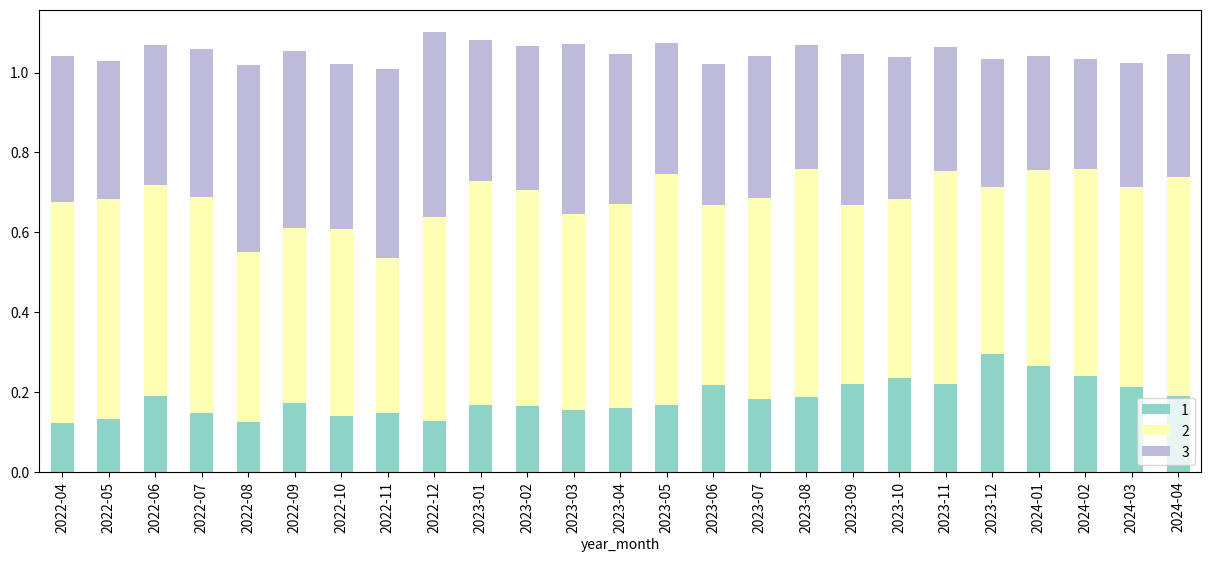

In [105]:
fig, ax = plt.subplots(figsize=(15, 6))
month_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

從主題分布來看，從上面LDAvis的比例推測，綠色主題應為「社會關係與個人觀點」，黃色主題占比最多，應為「個人情感與自我反思」。

可見憂鬱版的文章大多是分享個人在生活中的情緒和體悟，對多數發文者而言憂鬱版是用來宣洩心理壓力、尋求支持的地方。